# Dst Probabilistic Forecast

In this notebook, I first develop an class-balanced elastic-net-based CNN approach to model Dst Probabily during storm events and tested by an independent storm. The output is the Dst probability in next 24-48 hrs with a 2h time resolution. An emsemble method is developed for optimized the final predictions based on all 12 outputs within different samples. Please find the details in arxiv link:...

In [1]:
################ import package

import os
import time
import datetime as dt
import h5py
from multiprocessing import cpu_count, Pool
from ipdb import set_trace as st
from tqdm import tqdm
import warnings

import numpy as np
import numpy.linalg as LA
import linecache as lc
import pandas as pd

from scipy import io as sio
from sklearn.metrics import normalized_mutual_info_score
from scipy.signal import find_peaks

import matplotlib.pyplot as plt

from funs import SoHO_read, Read_solar_image, \
    dt2date, Prob_train, Ensemble_data, LS, \
    metric, ROC, prob_pred, SoHO_plot
    
import sklearn

warnings.filterwarnings('ignore')



## Configurations

All used variables, filenames and options are listed here.

You can simply change the number of 'storm_idx' to change the test event. The other events will be used for training and validation.  

In [2]:
###################### Config ######################
time_stamp = 'Data/time_data_19873_train_valid_test.h5' # SoHO_date file
channels = ['MDI','EIT','LASCO'] # channel names

dst_peak = -75 # peak Dst to seperate storm (1) from quiet (0) periods 
delay = 24 # start prediction(h). This means how many hours after SoHO images are taken 
time_res = 2 # time resolutions
Peak_width = 5 # for scipy function 'find_peak'
Peak_dis = 120 # for scipy function 'find_peak'
F107_thres = [0, 500] # F107 threshold
SDO_flag = 0 # if the SDO images are used for an external test (not valid anymore)
storm_idx = [13] # index of the test event
var_idx = [0, 1, 2] # channels selected for modeling
weight_len = 12 # length of predictions
iteration = 1 # how many iterations for ensemble method
lr = 1 # learning rate for ensemble method
train = False # if the CNN model needs to be trained/retrained

delay_range = weight_len*time_res
delay_hour_clu = range(delay, delay+delay_range, time_res)
hmi_file = 'Data/hmi_halloween2021.h5'

Res_name = 'Res/Dst_'+\
    str(delay)+'-'+\
    str(delay+delay_range) + '-'+\
    str(time_res) + '--'+\
    str(dst_peak)+'.h5'

# filename_Y = 'Results/Bz_GSE_0-48.h5'
callname = 'Res/params_'+\
    str(np.array(var_idx))+'_'+ \
    str(delay)+'-' +\
    str(delay+weight_len*time_res) +'--'+\
    str(time_res)+'-' +\
    str(dst_peak)+'-'+\
    str(storm_idx[0])+'.pt'

callname_opt = 'Res/params_opt_'+\
    str(np.array(var_idx))+'_'+ \
    str(delay)+'-' +\
    str(delay+weight_len*time_res) +'--'+\
    str(time_res)+'-' +\
    str(dst_peak)+'-'+\
    str(storm_idx[0])+'.pt'

figname_pred = 'Figs/test_proba_'+ \
            str(time_res)+'-' + \
            str(delay)+'-' + \
            str(delay+time_res*weight_len) + '--' + \
            str(dst_peak) + '-' \
            + str(storm_idx[0])+'.jpg'

figname_image = 'Figs/test_image_'+\
                  str(time_res)+'-' + \
                  str(delay)+'-' + \
                  str(delay+time_res*weight_len) + '--' + \
                  str(dst_peak) + '-' + \
                  str(storm_idx[0])+'.jpg'


## Data Reading

Read the ML-ready data set and corresponding date generated from the 'ML_ready_Data.ipynb'

In [3]:
################## data preparation #############

test_idx_clu = [0]
train_idx_clu = [0]
time_train = []
time_test = []

with h5py.File(Res_name, 'r') as f:

    idx = list(range(np.array(f['storm_num'])))
    if SDO_flag:
        pass
    else:
        for idx_test in storm_idx:
            if idx_test in idx:
                idx.remove(idx_test)
                # pass    
    # train
    X_train = np.array(f['X_{}'.format(idx[0])])
    Y_train = np.array(f['Y_{}'.format(idx[0])])
    Y_reg_train = np.array(f['Y_reg_{}'.format(idx[0])])
    time_train.append(np.array(f['time_{}'.format(idx[0])]))
    for i in tqdm(range(1, len(idx))):
        train_idx_clu.append(len(Y_train))
        time_train.append(np.array(f['time_{}'.format(idx[i])]))
        X_train = np.vstack([X_train, \
            np.array(f['X_{}'.format(idx[i])])])
        Y_train = np.vstack([Y_train, \
            np.array(f['Y_{}'.format(idx[i])])])
        Y_reg_train = np.vstack([Y_reg_train,
                                 np.array(f['Y_reg_{}'.format(idx[i])])])
    train_idx_clu.append(len(Y_train))

    if SDO_flag:

        X_test = np.array(f['X_ex'])
        Y_test = np.array(f['Y_ex'])
        Y_reg_test = np.array(f['Y_reg_ex'])
        time_test.append(np.array(f['time_ex']).astype(int))
    
    else:
        # test
        X_test = np.array(f['X_{}'.format(storm_idx[0])])
        Y_test = np.array(f['Y_{}'.format(storm_idx[0])])
        Y_reg_test = np.array(f['Y_reg_{}'.format(storm_idx[0])])
        time_test.append(np.array(f['time_{}'.format(storm_idx[0])]))
        test_idx_clu.append(len(Y_test))
    f.close()

X = X_train[:, var_idx]
Y = Y_train
Y_reg = Y_reg_train

date_train = np.concatenate(time_train).ravel().reshape(-1, 2)

X_t = X_test[:, var_idx]
Y_t = Y_test
Y_reg_t = Y_reg_test
date_test = np.concatenate(time_test).ravel().reshape(-1, 2)
date_t = []
date_image = []
for i in range(date_test.shape[0]):
    date_t.append(dt2date(date_test[i], time_res)+\
        dt.timedelta(hours=delay))
    date_image.append(dt2date(date_test[i], time_res))

print(X.shape)
print(Y.shape)
print(X_t.shape)
print(Y_t.shape)

100%|██████████| 19/19 [00:03<00:00,  4.83it/s]


(1886, 3, 256, 256)
(1886, 12)
(145, 3, 256, 256)
(145, 12)


## Modeling

First train a model for the Dst probability (by function 'Prob_train');

An ensemble data set is then extracted from the model output (by function 'Ensemble_data');

The weights for the ensemble data set is optimized using the least-squares method (by function 'LS')

Final predictions of the test event (by function 'prob_pred') and corresponding SoHO images (by function 'SoHO_plot') are also plotted and saved. Final MCC/TSS scores are also printed.

Final train MCC/TSS: 0.4599862053759541/0.615120806580542
Final test MCC/TSS: 0.6615474369505149/0.7335082458770614


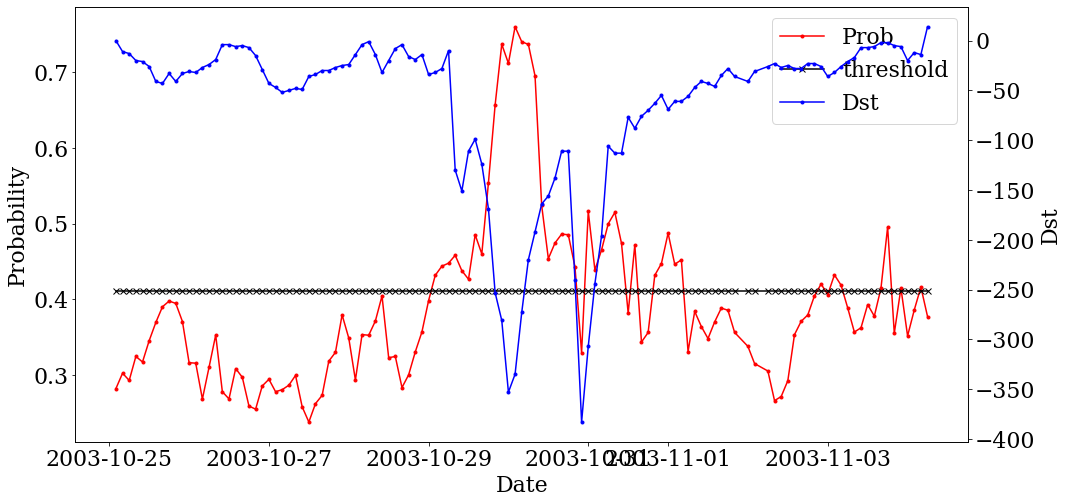

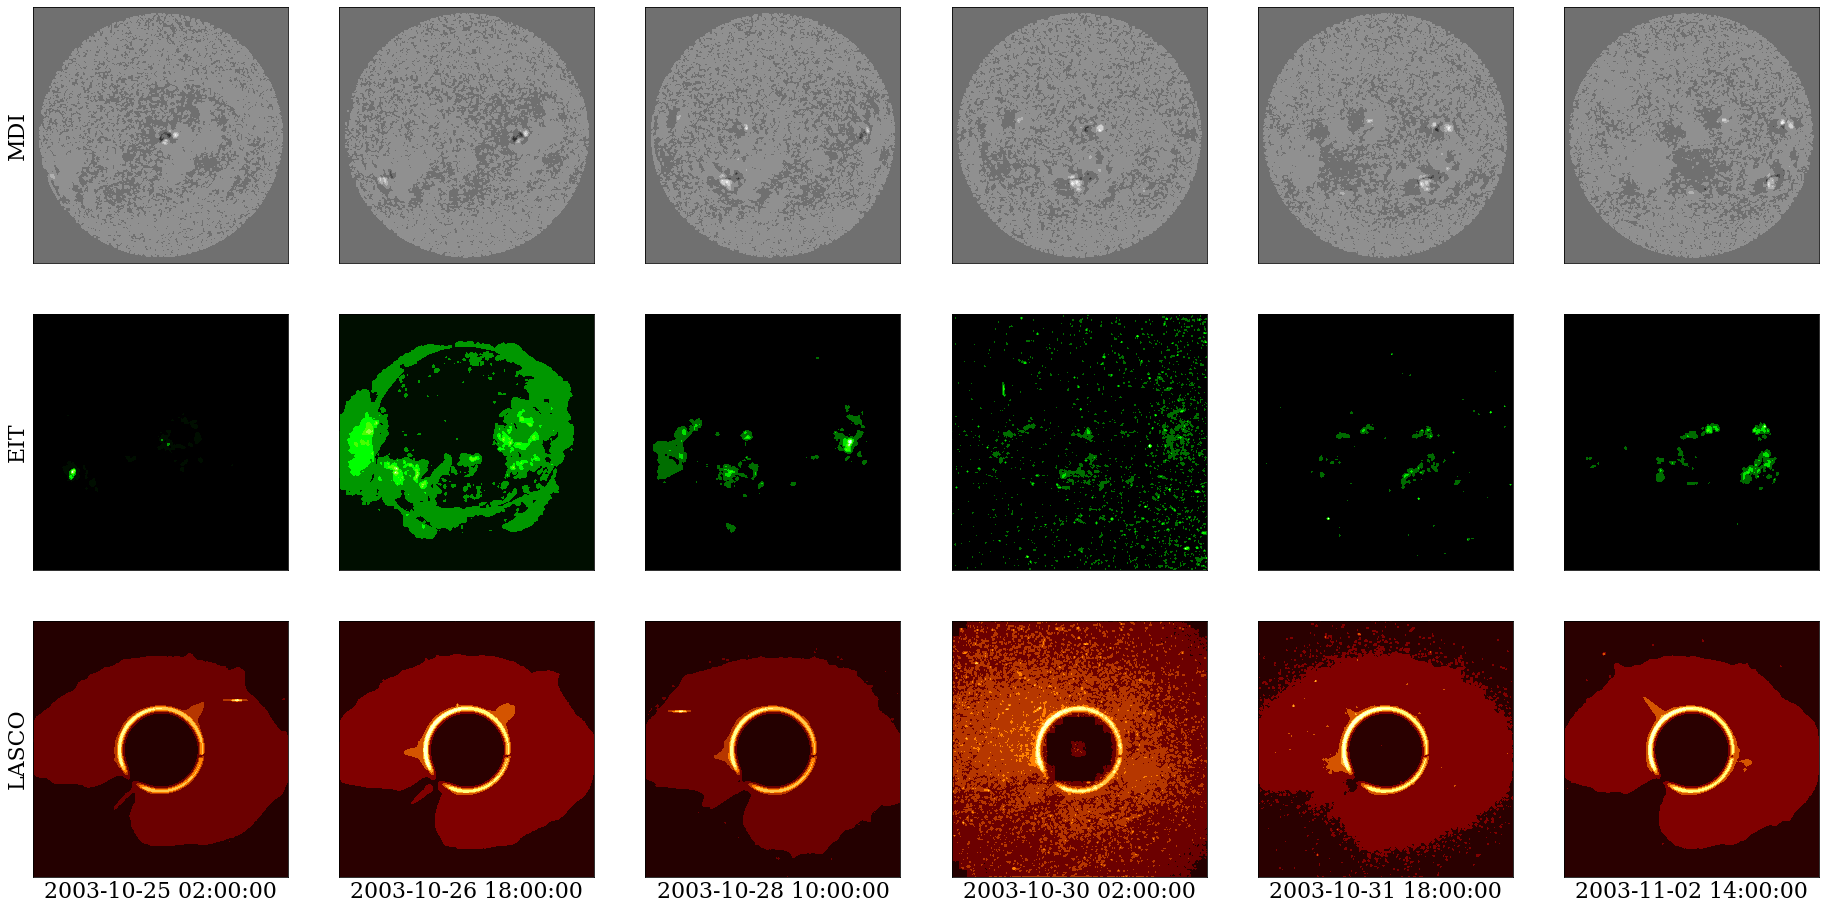

In [4]:
###################### modeling ###############

weights = np.ones(weight_len)/weight_len

for iter in range(iteration):
    Y_train_prob = Prob_train(X, Y_reg, X, Y, 
           delay, 
           len(var_idx), dst_peak,
           callname, 
           train=train,
           )
    
    Y_test_prob = Prob_train(X, Y_reg, X_t, Y_t, 
           delay, 
           len(var_idx), dst_peak,
           callname, 
           train=False,
           )

    Y_pred_all, Y_all_reg, Y_all, thres_clu, P = \
        Ensemble_data(Y_train_prob, Y_reg, Y, 
                train_idx_clu, weight_len, dst_peak,
                weights)

    Y_pred_t, _, Y_all_t, _, _ = \
        Ensemble_data(Y_test_prob, Y_reg_t, Y_t, 
                test_idx_clu, weight_len, dst_peak,
                weights)

    weights = LS(Y_pred_all, Y_all_reg, P,
        weight_len, lr, iter, 
        weights)

    Y_train_prob = np.dot(Y_pred_all, weights)
    Y_test_prob = np.dot(Y_pred_t, weights)
    _, _, _, thres_train, _ = ROC(Y_all,
                                  Y_train_prob) 

    MCC, TSS = metric(Y_train_prob, Y_all, thres_train)
    print('Final train MCC/TSS: {}/{}'.format(MCC, TSS))
    MCC, TSS = metric(Y_test_prob, Y_all_t, thres_train)
    print('Final test MCC/TSS: {}/{}'.format(MCC, TSS))

    prob_pred(Y_test_prob, Y_reg_t[12:-12, 0], 
              date_t[12:-12], thres_train, figname_pred)

    SoHO_plot(X_t[12:-12], Y_reg_t[12:-12], date_t[12:-12],
              var_idx, 
              figname_image)